In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.metrics import r2_score, mean_squared_error
import random, pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [60]:
# utils
def oh_encode_data(df, cols):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_df = pd.DataFrame(encoder.fit_transform(df[cols]), index=df.index)
    encoded_df.columns = encoder.get_feature_names_out(cols)

    return encoded_df

def model_notation(columns):
    """
    Encodes a list of column names into a model notation string.
    The notation follows the format 'y ~ x1 + x2 + x3' for simple columns,
    and 'y ~ x1 * x2 + x3' for interaction terms.
    """
    terms = []
    for col in sorted(columns):
        if '_' in col:
            col = col.split('_')
            col = [s[0].upper() for s in col]
            terms.append("*".join(col))
        else:
            terms.append(col[0].upper())
    model_notation = 'S ~ ' + ' + '.join(terms)
    return model_notation

In [59]:
# main data generation
def generate_data(n=1000):
    np.random.seed(0)

    data = {
        'age': np.random.choice(age_levels, n),
        'work': np.random.choice(work_levels, n),
        'education': np.random.choice(education_levels, n),
        'country': np.random.choice(country_codes, n),
        'race': np.random.choice(races, n),
        'gender': np.random.choice(genders, n),
        'maritalStatus': np.random.choice(marital_statuses, n),
        'occupation': np.random.choice(occupations, n),
        # 'occupation': np.random.choice(occupations_minus_ceo, n),
    }
    df = pd.DataFrame(data)

    # Enforce 50% married women
    # married_female_indices = np.random.choice(df.index, size=int(n * 0.5), replace=False) ????
    # df.loc[married_female_indices, 'maritalStatus'] = 'married'
    # df.loc[married_female_indices, 'gender'] = 'F'

    # keep #ceos small
    # ceo_indices = np.random.choice(df.index, size=int(n * 0.01), replace=False) # bad for rand gen sampling
    # df.loc[ceo_indices, 'occupation'] = 'CEO'

    df['occupationWeight'] = df['occupation'].map(occupation_weights)
    df['educationWeight'] = df['education'].map(education_level_weights)
    df['workWeight'] = df['work'].map(work_class_weights)
    df['countryWeight'] = df['country'].apply(lambda x: country_weights[country_codes.index(x)])
    df['maritalStatus_gender'] = df['maritalStatus'] + '_' + df['gender']
    df['maritalStatus_genderWeight'] = df['maritalStatus_gender'].map(marital_status_gender_weights)

    df['salary'] = (df['occupationWeight'] + df['maritalStatus_genderWeight'] +
                    df['educationWeight'] + df['workWeight'] +
                    df['countryWeight']) * 8000
    # add noise
    df['salary'] += np.random.normal(0, 3000, n)

    df.drop(columns=['occupationWeight', 'educationWeight', 'workWeight',
                     'countryWeight', 'maritalStatus_gender', 'maritalStatus_genderWeight'],
            inplace=True)

    print("internal model made from:", model_notation(['occupation', 'education', 'work', 'country',
                                                       'maritalStatus_gender']))

    return df

In [64]:
age_levels = ['19-29', '30-44', '45-60']
education_levels = ['school', 'bachelors', 'masters+']
work_levels = ['private', 'public', 'self']
country_codes = ['US', 'GB', 'CA', 'FR', 'DE', 'JP', 'CN', 'IN', 'BR', 'RU',
                 'IT', 'AU', 'ZA', 'ES', 'KR', 'SE', 'CH', 'TR', 'NL', 'MX']
races = ['W', 'B', 'A']
genders = ['M', 'F']
marital_statuses = ['single', 'married', 'divorced']
occupations = ['sales', 'custserv', 'clerk', 'cashier', 'sec', 'teacher',
               'nurse', 'account', 'dev', 'eng', 'doc', 'CEO']
# occupations_minus_ceo = ['Sales', 'CustServ', 'Clerk', 'Cashier', 'Sec', 'Teacher',
            #    'Nurse', 'Account', 'Dev', 'Eng', 'Doc']
# skewed weights for female based on marital_status
marital_status_gender_weights = { 'married_F': 4, 'married_M': 16, 'single_F': 20,
                                 'single_M': 18, 'divorced_F': 15, 'divorced_M': 14}
education_level_weights = {'school': 3, 'bachelors': 4, 'masters+': 6}
work_class_weights = {'private': 1, 'public': 1.5, 'self': 2}
country_weights = np.linspace(0, 1, 20)
occupation_weights = {
    'CEO': 12, 'eng': 6, 'doc': 6, 'dev': 5,
    'sales': 2, 'custserv': 1, 'clerk': 1, 'cashier': 2, 'sec': 1.5, 'teacher': 3,
    'nurse': 4, 'account': 5.5
}
column_values_count = {
    'age': len(age_levels),  # 3 unique values
    'work': len(work_levels),  # 3 unique values
    'education': len(education_levels),  # 3 unique values
    'country': len(country_codes),  # 20 unique values
    'race': len(races),  # 3 unique values
    'gender': len(genders),  # 2 unique values
    'maritalStatus': len(marital_statuses),  # 3 unique values
    'occupation': len(occupations)  # 12 unique values
}
# Generate dataset
np.random.seed(0)  # For reproducibility
data = generate_data(2000)
print(f"average salary: {int(data['salary'].mean())}")
input_data = data.drop('salary', axis = 1)

encoder = OneHotEncoder(sparse = False)
X = encoder.fit_transform(data.drop('salary', axis=1))
y = data['salary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\nnaive full model (using all 1st order features directly)\nR2: {r2:.5f}, \nMSE over salary value: {mse:.1f}")

internal model made from: S ~ C + E + M*G + O + W
average salary: 199555

naive full model (using all 1st order features directly)
R2: 0.70032, 
MSE over salary value: 670962217.2


In [70]:
def add_n_combinations_of_2(data):
  '''function used for generating the combination columns
  the final data (refined_data) has list of n plus nc2 combinations'''
  refined_data = data.copy()
  column_names = refined_data.columns
  combinations_2 = list(combinations(column_names, 2))
  for combo in combinations_2:
      new_column_name = f"{combo[0]}_{combo[1]}"
      refined_data[new_column_name] = refined_data[combo[0]] + "_" + refined_data[combo[1]]
  return refined_data

# def subset_creation(actual_col_list, interaction_cols_list, refined_data,list_values,k_probabilities):
#   '''Created a subset using the following assumptions:
#    a) the number of picks from n samples must be more than the number of picks from nc2 samples.
#    b) the number of  picks from nc2 samples must be either 0,1 or 2 and we are defining probabilities for picking these values.
#   '''

#   random_original_columns = random.sample(list(actual_col_list), k= random.randint(1,len(actual_col_list)))
#   p = random.choices(list(k_probabilities.keys()), weights=k_probabilities.values())[0]
#   k_min = min(p,len(random_original_columns))
#   random_combinations_columns_wo_intersection = [value for value in interaction_cols_list if all(elem not in random_original_columns for elem in value.split('_'))]
#   if len(random_combinations_columns_wo_intersection) < k_min:
#     k_min = len(random_combinations_columns_wo_intersection)
#   random_combinations_columns = random.sample(random_combinations_columns_wo_intersection, k = k_min)
#   subset_data_with_interactions = refined_data[random_original_columns + random_combinations_columns]

#   return subset_data_with_interactions

def subset_creation(actual_col_list, interaction_cols_list, refined_data, list_values, k_probabilities):
  '''Created a subset using the following assumptions:
   a) the number of picks from n samples must be more than the number of picks from nc2 samples.
   b) the number of  picks from nc2 samples must be either 0, 1 or 2 and we are defining probabilities for picking these values.
  '''

  k_comb = random.choices(list(k_probabilities.keys()), weights=k_probabilities.values())[0]
  random_combinations_columns = random.sample(interaction_cols_list, k = k_comb)
  individual_interaction_columns = set(column for combined_features in random_combinations_columns for column in combined_features.split('_'))
  original_columns_wo_intersection = [column for column in actual_col_list if column not in individual_interaction_columns]
  random_original_columns = random.sample(list(original_columns_wo_intersection), k = random.randint(1,len(original_columns_wo_intersection)))
  subset_data_with_interactions = refined_data[random_original_columns + random_combinations_columns]

  return subset_data_with_interactions, random_original_columns + random_combinations_columns

def subset_fit_model_score(subset, y):
  '''In this function we are fitting the subset and calculating the required metrix after performing the one-hot encoding on the categorical columns.'''
  encoder = OneHotEncoder()
  X = encoder.fit_transform(subset)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  reg = LinearRegression()
  reg.fit(X_train, y_train)
  y_pred = reg.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  return reg, r2, mse

def get_num_params(columns):
  total_values = 0
  for col in columns:
      if '_' in col:
          parts = col.split('_')
          col_value = 1
          for part in parts:
              col_value *= column_values_count[part]
          total_values += col_value
      else:
          total_values += column_values_count[col]
  return total_values

def main(X, y, samples_range):
  ''' Samples N times and return the best model'''
  refined_data = add_n_combinations_of_2(X)
  actual_col_list =  refined_data.columns[:(len(X.columns))]
  interaction_cols_list =  [value for value in refined_data.columns if value not in actual_col_list]

  max_r2 = 0
  best_subset_model = {"model":"", "dataset": "", "r2_score": 0}
  sampled_iters = []
  best_r2_at_iter = []
  for limit in range(0,samples_range):
    subset_data, columns = subset_creation(actual_col_list, interaction_cols_list, refined_data, list_values, k_probabilities)
    model, subset_r2, subset_mse = subset_fit_model_score(subset_data, y)

    if model_notation(columns) == "S ~ C + E + M*G + O + W":
      print("reached best model")

    if best_subset_model['r2_score'] < subset_r2:
      best_subset_model['r2_score'] = subset_r2
      best_subset_model['model'] = model
      best_subset_model['dataset'] = subset_data
      print(f"At iter {limit} found new best:\t", model_notation(columns), f"\tof score {subset_r2:.5f} has {get_num_params(columns)} params")

      sampled_iters.append(limit+1)
      best_r2_at_iter.append(best_subset_model['r2_score'])
    # if (limit+1) % 10 == 0:

  return {
        "best_subset_model": best_subset_model,
        "sampled_iters": sampled_iters,
        "best_r2_at_iter": best_r2_at_iter
    }

In [71]:
%%time
print("true target model is:\tS ~ C + E + G*M + O + W")
X = data.drop('salary', axis = 1)
y = data['salary'].values

list_values = [0, 1, 2]
k_probabilities = {0: 0.4, 1: 0.5, 2: 0.1}
samples_range = 5000

result = main(X, y, samples_range)

true target model is:	S ~ C + E + G*M + O + W
At iter 0 found new best:	 S ~ C + O 	of score 0.26997 has 32 params
At iter 1 found new best:	 S ~ G + O 	of score 0.35420 has 14 params
At iter 2 found new best:	 S ~ C*M + O + W 	of score 0.59001 has 75 params
At iter 6 found new best:	 S ~ G + M + O 	of score 0.66560 has 17 params
At iter 11 found new best:	 S ~ A + C + G + O + R*M + W*E 	of score 0.70289 has 55 params
At iter 27 found new best:	 S ~ C + E + G*M + O + R 	of score 0.99061 has 44 params
At iter 73 found new best:	 S ~ A + E + G*M + O + R + W 	of score 0.99345 has 30 params
At iter 293 found new best:	 S ~ A + C + E + G*M + O + R + W 	of score 0.99566 has 50 params
At iter 3434 found new best:	 S ~ C + E + G*M + O + W 	of score 0.99568 has 44 params
At iter 4284 found new best:	 S ~ A + C + E + G*M + R + W*O 	of score 0.99572 has 71 params
CPU times: user 1min 11s, sys: 274 ms, total: 1min 11s
Wall time: 1min 17s


At iter 3434, true model was captured. The better scoring model found later is overfit with more parameters (a superset of the already found true model), both have the almost same score.

In [72]:
df = pd.DataFrame({
    'sampled_iters': result['sampled_iters'],
    'best_r2_at_iter': result['best_r2_at_iter']
})
csv_filename = 'model_results.csv'
df.to_csv(csv_filename, index=False)

print(f"Results have been saved to {csv_filename}")

Results have been saved to model_results.csv


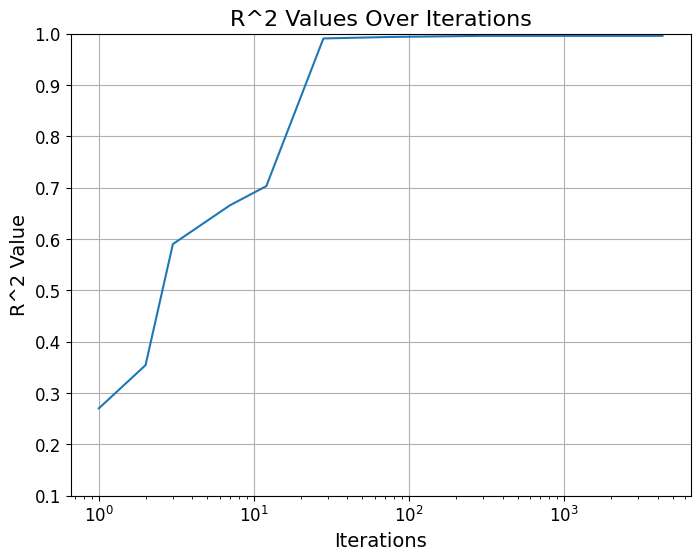

{'model': LinearRegression(),
 'dataset':      race  education country    age  work_occupation gender_maritalStatus
 0       W   masters+      TR  19-29     public_clerk             F_single
 1       B  bachelors      GB  30-44   public_account             M_single
 2       A  bachelors      GB  19-29  private_account           M_divorced
 3       W     school      IN  30-44  public_custserv           M_divorced
 4       A  bachelors      US  30-44      private_sec           M_divorced
 ...   ...        ...     ...    ...              ...                  ...
 1995    B   masters+      ES  19-29      private_sec             M_single
 1996    B     school      GB  45-60    private_sales            F_married
 1997    B   masters+      KR  19-29       self_clerk           F_divorced
 1998    A  bachelors      ZA  30-44     public_nurse           M_divorced
 1999    B   masters+      US  45-60     self_account             M_single
 
 [2000 rows x 6 columns],
 'r2_score': 0.9957167958335483

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(result['sampled_iters'], result['best_r2_at_iter'])  # Removed the marker to not dot individual points
plt.xscale('log')
plt.ylim(0.1, 1)
plt.title('R^2 Values Over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('R^2 Value', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

result['best_subset_model']

In [78]:
print(result.keys())

dict_keys(['best_subset_model', 'sampled_iters', 'best_r2_at_iter'])
